In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from matplotlib import pyplot
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       VarianceThreshold, chi2)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (LinearRegression, LogisticRegression, PassiveAggressiveClassifier,
                                  Perceptron, RidgeClassifier, SGDClassifier)
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, log_loss,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import (BernoulliNB, ComplementNB, GaussianNB,
                                 MultinomialNB)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (Binarizer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler,
                                   normalize)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
traindf = pd.read_csv('../data/train.csv', index_col="ID")
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31097,Resort Hotel,1,18,2016,March,13,21,1,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,NaN,0,Transient,62.510311,0,0,Canceled,2016-03-08
32218,City Hotel,0,13,2016,March,14,27,2,2,2,0.0,0,BB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,138.0,NaN,0,Transient,87.463148,0,0,Check-Out,2016-03-31


### Drop columns not in test data and Clean missing data
* Drop columns: `adr`, `reservation_status`, `reservation_status_date`

In [4]:
testCol = set(pd.read_csv('../data/test.csv', index_col="ID").columns)
removeCols = [col for col in traindf.columns if col not in testCol]
removeCols.remove("is_canceled")
print(removeCols)

['adr', 'reservation_status', 'reservation_status_date']


In [5]:
traindf = traindf.drop(removeCols, axis=1)
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36122,City Hotel,0,90,2016,April,17,19,0,3,2,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,0,1
47331,City Hotel,0,36,2016,June,26,19,2,1,2,0.0,0,BB,FIN,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,0,1


The below code shows column name of missing data

In [6]:
tmp = pd.to_numeric((traindf.isnull().sum() / traindf.shape[0]).map('{:,.2f}'.format))
tmp[tmp > 0]

country    0.01
agent      0.14
company    0.94
dtype: float64

* The company feature's 94% is missing. Because of that, this feature will be eliminated. 
* Another missing data has occurred in country and agent features. Since missing data of country is less than 1%, these data will replace with most frequent value. 
* However, the agent missing features are more than the country. For this feature, missing data will be imputed as 0

In [7]:
traindf["children"] = traindf["children"].fillna(0)
traindf["country"] = traindf["country"].fillna(traindf["country"].mode().index[0])
traindf["agent"] = traindf["agent"].fillna("0")
traindf = traindf.drop(["company"], axis=1)

In [8]:
traindf.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6963,City Hotel,1,321,2015,September,36,3,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,1,1,0,A,A,0,No Deposit,1,0,Transient-Party,0,0
38226,City Hotel,0,43,2016,April,18,30,1,1,2,1.0,0,BB,ESP,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,7,0,Transient,0,1
2201,City Hotel,1,281,2015,July,30,25,2,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,No Deposit,1,0,Transient-Party,0,0
18172,City Hotel,0,80,2015,November,47,20,1,2,2,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,A,0,No Deposit,14,0,Group,1,0
73459,City Hotel,0,31,2016,November,47,19,0,1,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,0,2


### Feature Transformation

`date`: Combine `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number` to date object
<br>One hot encoding `arrival_date_month`

In [9]:
# def create_date(year: pd.Series, month: pd.Series, date: pd.Series) -> pd.Series:
#     return pd.to_datetime(year.astype(str) + month + date.astype(str), format="%Y%B%d")

# traindf.insert(loc=0, column="date", 
#           value=create_date(traindf["arrival_date_year"], traindf["arrival_date_month"], traindf["arrival_date_day_of_month"]))
# traindf = traindf.drop(["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis=1)

month = pd.get_dummies(traindf.arrival_date_month)
traindf = pd.concat([traindf, month], axis=1, join="inner")
traindf = traindf.drop(["arrival_date_month"], axis=1)

`hotel`: Convert hotel as `Resort Hotel` to 0, `City Hotel` to 1

In [10]:
traindf["hotel"] = traindf["hotel"].map({"Resort Hotel": 0, "City Hotel": 1})

Create new feature `is_same_room`: Check if `reserved_room_type` is same as `assigned_room_type`(If so 1, else 0)
<br>One hot encoding `reserved_room_type` and `assigned_room_type`

In [11]:
traindf["is_same_room"] = (traindf["reserved_room_type"] == traindf["assigned_room_type"]).map({True: 1, False: 0})
reserved = pd.get_dummies(traindf.reserved_room_type, prefix="reserved_")
assigned = pd.get_dummies(traindf.assigned_room_type, prefix="assigned_")
traindf = pd.concat([traindf, reserved, assigned], axis=1, join="inner")
traindf = traindf.drop(["reserved_room_type", "assigned_room_type"], axis=1)

`children`: `children` + `babies`

In [12]:
traindf["children"] = traindf["children"] + traindf["babies"]
traindf = traindf.drop(["babies"], axis=1)

One hot encoding: `meal`

In [13]:
meal = pd.get_dummies(traindf.meal, prefix="meal_")
traindf = pd.concat([traindf, meal], axis=1, join="inner")
traindf = traindf.drop(["meal"], axis=1)

Classify `country` to `proneToCancel`, `neutralToCancel`, `notProneToCancel` based on canceled rate
* `proneToCancel`: canceled rate >= 0.5
* `neutralToCancel`: 0.3 < canceled rate < 0.5
* `notProneToCancel`: canceled rate <= 0.3

In [14]:
def country_cancel_tendency(traindf):
    tmp = traindf[["country", "is_canceled"]].groupby("country").agg({'country': 'count', 'is_canceled': 'mean'})
    proneToCancel = set(tmp[tmp.is_canceled > 0.5]["country"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["country"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["country"].index)
    
    traindf["countryProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["countryNeutralToCancel"] = traindf["country"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["countryNotProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["country"], axis=1)
    
    return traindf

traindf = country_cancel_tendency(traindf)

In [15]:
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,April,August,December,February,January,July,June,March,May,November,October,September,is_same_room,reserved__A,reserved__B,reserved__C,reserved__D,reserved__E,reserved__F,reserved__G,reserved__H,reserved__L,reserved__P,assigned__A,assigned__B,assigned__C,assigned__D,assigned__E,assigned__F,assigned__G,assigned__H,assigned__I,assigned__K,assigned__L,assigned__P,meal__BB,meal__FB,meal__HB,meal__SC,meal__Undefined,countryProneToCancel,countryNeutralToCancel,countryNotProneToCancel
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9548,1,1,74,2015,38,18,0,2,2,0.0,Offline TA/TO,TA/TO,0,0,0,0,Non Refund,6,0,Transient-Party,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
6876,0,1,244,2015,36,2,2,5,2,0.0,Groups,TA/TO,0,1,0,0,No Deposit,96,0,Transient-Party,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Classify `agent` to `agentProneToCancel`, `agentNeutralToCancel`, `agentNotProneToCancel` based on canceled rate
* `agentLikelyToCancel`: canceled rate > 0.75
* `agentProneToCancel`: 0.5 < canceled rate <= 0.75
* `agentNeutralToCancel`: 0.3 < canceled rate <= 0.5
* `agentNotProneToCancel`: canceled rate <= 0.3

In [16]:
def agent_cancel_tendency(traindf):
    tmp = traindf[["agent", "is_canceled"]].groupby("agent").agg({'agent': 'count', 'is_canceled': 'mean'})
    likelyToCancel = set(tmp[tmp.is_canceled > 0.75]["agent"].index)
    proneToCancel = set(tmp[(tmp.is_canceled <= 0.75) & (tmp.is_canceled > 0.5)]["agent"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["agent"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["agent"].index)
    
    traindf["agentLikelyToCancel"] = traindf["agent"].apply(lambda x: 1 if x in likelyToCancel else 0)
    traindf["agentProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["agentNeutralToCancel"] = traindf["agent"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["agentNotProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["agent"], axis=1)
    
    return traindf

traindf = agent_cancel_tendency(traindf)

### Train Model and Evaluate best model performance

In [17]:
traindf = pd.get_dummies(traindf)
new_train_x = traindf.drop("is_canceled", axis=1).values
new_train_y = traindf["is_canceled"].values

In [18]:
classifiers = [XGBClassifier(),
               ExtraTreesClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               RidgeClassifier(),
               QuadraticDiscriminantAnalysis(),
               ComplementNB(),
               BernoulliNB(),
               GaussianNB(),
               MultinomialNB(),
               LinearDiscriminantAnalysis(),
               SGDClassifier(),
               AdaBoostClassifier(),
               BaggingClassifier(),
               LogisticRegression(),
               LinearSVC(),
               KNeighborsClassifier()
               ]

from time import time

for clf in classifiers:
    
    before = time()
    print("="*30)
    print(clf.__class__.__name__)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    crossValScore = cross_val_score(clf, new_train_x, new_train_y, scoring='balanced_accuracy', cv=skf)  
    crossValScore_mean = np.mean(crossValScore) 
    print("Stratified Cross Validation Score, balanced_accuracy: {:.4}".format(crossValScore_mean))
    after = time()
    print(f"花費{(after - before):.1f}s")
    
print("="*30)

XGBClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.8473
花費51.9s
ExtraTreesClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.882
花費39.2s
DecisionTreeClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.864
花費3.3s
RandomForestClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.8905
花費34.9s
RidgeClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.7718
花費1.6s
QuadraticDiscriminantAnalysis
Stratified Cross Validation Score, balanced_accuracy: 0.6959
花費2.6s
ComplementNB
Stratified Cross Validation Score, balanced_accuracy: 0.6324
花費0.5s
BernoulliNB
Stratified Cross Validation Score, balanced_accuracy: 0.7452
花費0.9s
GaussianNB
Stratified Cross Validation Score, balanced_accuracy: 0.7122
花費0.7s
MultinomialNB
Stratified Cross Validation Score, balanced_accuracy: 0.6314
花費0.5s
LinearDiscriminantAnalysis
Stratified Cross Validation Score, balanced_accuracy: 0.7745
花費4.7s
SGDClassifier
Stratified Cross Validation Score

In [19]:
X_train, X_test, y_train, y_test = train_test_split(new_train_x, new_train_y, test_size=0.3)
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     17737
           1       0.89      0.83      0.86      9723

    accuracy                           0.90     27460
   macro avg       0.90      0.89      0.89     27460
weighted avg       0.90      0.90      0.90     27460



### Feature Importance

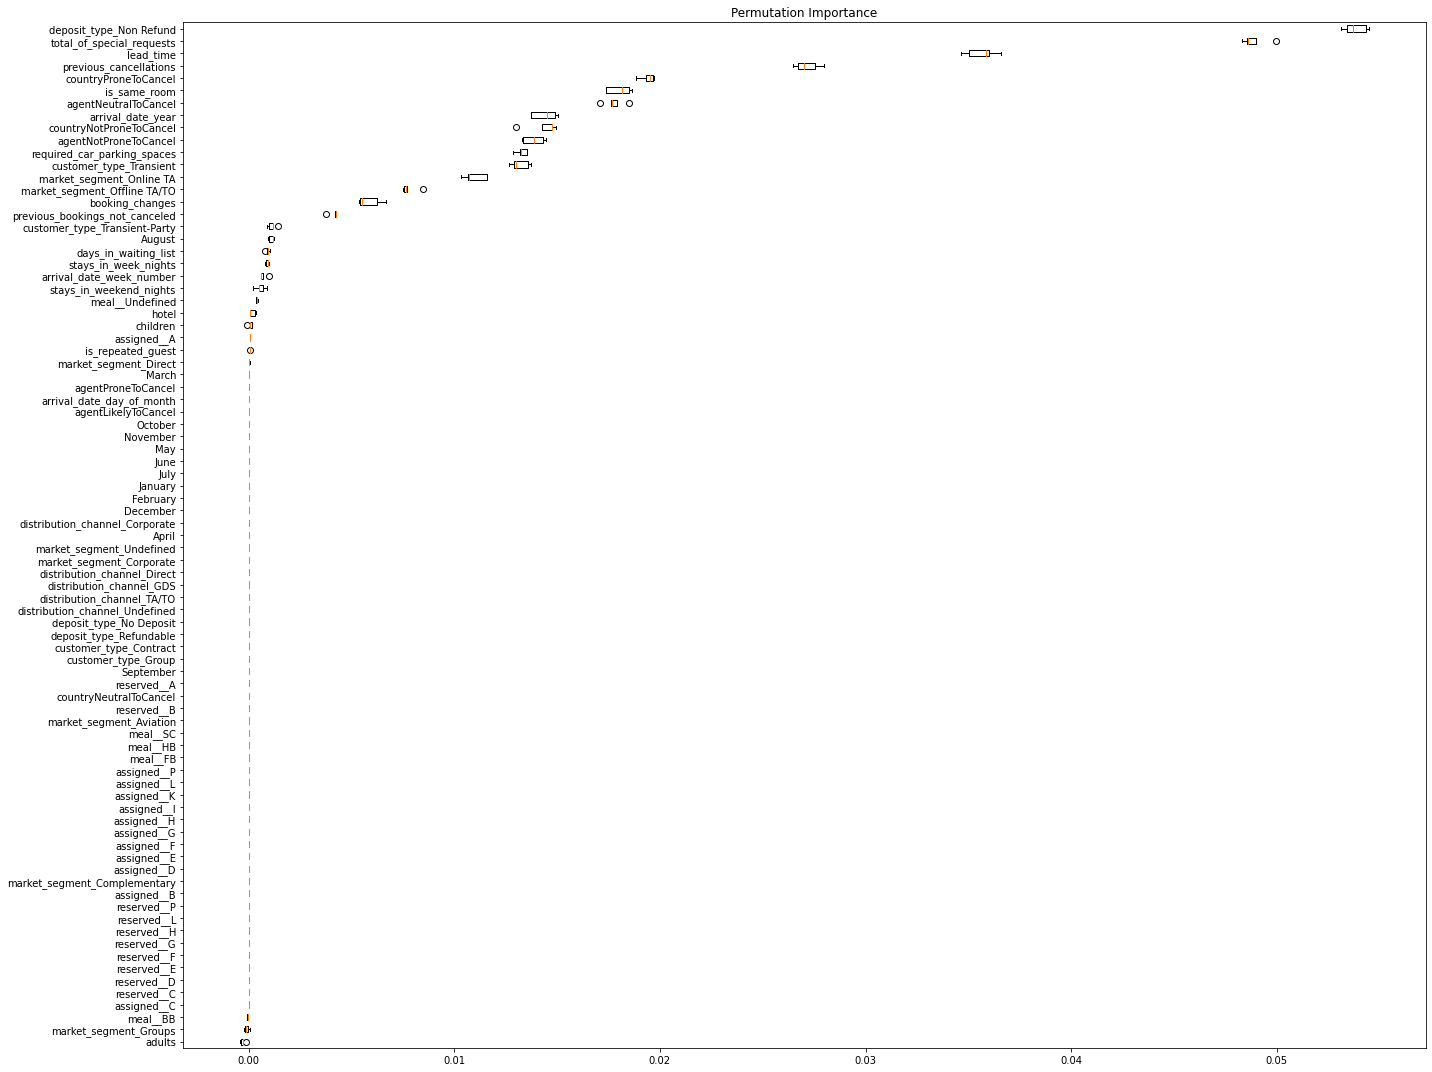

In [20]:
model = XGBClassifier()
model = model.fit(X_train, y_train)
result = permutation_importance(model, X_train, y_train, scoring="accuracy", n_repeats=5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(20, 15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=traindf.drop("is_canceled", axis=1).columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

### Dump model for future usage

In [21]:
# import pickle

# with open("cancel.pkl", "wb+") as file:
#     pickle.dump(clf, file)